### import libraries ###

In [285]:
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.compose import ColumnTransformer
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, InputLayer
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import EarlyStopping



### Helper Functions

In [286]:
def EDA(df):
    '''
    Data Exploring and Preprocessing (EDA)
    To find insights to help with Data cleaning/preparation/transformation, which will ultimately be used into a machine learning algorithm. The following steps are followed:
    1. Print headings of the dataset
    2. Print info of dataset
    3. Count class numbers: binary vs multi-class
    '''
    df.head()
    print(df.info())
    print(Counter(df['class']))

In [287]:
def dataProcessing(df):
    '''
    preprocess the datasets by spliting datasets to train and test sets, standardize numerical features, and transfomr multiclass labels to binary vectors
    input: dataset
    output: training and testing datasets: X_train_scaled, X_test_scaled, Y_train, Y_test
    '''
    features = df.iloc[:,0:-1]
    labels = df.iloc[:,-1]
    # split datasets to train and test
    X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2,random_state=42, stratify=labels )
    # standardize numerical values
    numerical_features = features.select_dtypes(include=['float64','int64'])
    numerical_columns = numerical_features.columns
    ct = ColumnTransformer([("numeric",StandardScaler(),numerical_columns)])
    # apply standardization to training and testing features
    X_train_scaled = ct.fit_transform(X_train)
    X_test_scaled = ct.fit_transform(X_test)

    ## Prepare labels for multi-class classification
    le = LabelEncoder()
    Y_train = le.fit_transform(Y_train.astype(str))
    Y_test = le.transform(Y_test.astype(str))
    # transform labels into a binary vector
    Y_train = to_categorical(Y_train)
    Y_test = to_categorical(Y_test)

    return X_train_scaled, X_test_scaled, Y_train, Y_test


In [288]:
def modelBuilding(X_train):
    '''
    Design the neural network model
    input: training data
    output: model
    '''
    model = Sequential()
    #input layer
    model.add(InputLayer(input_shape = (X_train.shape[1],)))
    # hidden layers
    model.add(Dense(128,activation='relu'))
    #model.add(layers.Dropout(0.1))
    model.add(Dense(64,activation='relu'))
    #model.add(layers.Dropout(0.2))
    model.add(Dense(32,activation='relu'))
    #model.add(layers.Dropout(0.2))
    model.add(Dense(16,activation='relu'))
    model.add(layers.Dropout(0.2))
    # output layer
    model.add(Dense(7,activation='softmax'))
    # optimizer
    opt = Adam(learning_rate = 0.001)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [289]:
def modelEval(model,X_test,Y_test,history):
    '''
    evaluate the model with test data give classification report
    input: model,X_test,Y_test,history
    output: y_estimate, y_true, class_names
    '''

    y_estimate = model.predict(X_test, verbose = 0)
    y_estimate = np.argmax(y_estimate, axis=1)
    y_true = np.argmax(Y_test, axis=1)

    class_names = ['Spruce/Fir', 'Lodgepole Pine',
                   'Ponderosa Pine', 'Cottonwood/Willow',
                   'Aspen', 'Douglas-fir', 'Krummholz']
    print(classification_report(y_true, y_estimate, target_names=class_names))

    fig = plt.figure()
    # plot loss and accuracy over each epoch

    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'validation'], loc='upper left')


    # Plot loss and val_loss over each epoch
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'validation'], loc='upper left')
    plt.show()

    return y_estimate, y_true, class_names

In [290]:
def plot_heatmap(class_names, y_pred, y_test):
    """
    Function to compute a Confusion Matrix and plot a heatmap based on the matrix.
    input: class names, y-predicted, y-test (ground-truth)
    output: a PNG file of the heatmap.
    """
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    # Save the heatmap to file
    heatmapfig = heatmap.get_figure()
    # heatmapfig.savefig(f'../output/confusion_matrix.png')

### main function
    The main function below drives the entire code. 
    It prepares the dataset, builds a model with appropriate parameters, evaluates the model and predicts on the test data. Finally, plots some performance metrics.

In [291]:
def main():
    df = pd.read_csv('cover_data.csv')
    # to run EDA, uncomment line below
    # EDA(df)
    # Data processing
    X_train, X_test, Y_train, Y_test = dataProcessing(df)
    # Build the model
    model = modelBuilding(X_train)
    model.summary()
    # model training
    EPOCHS = 100
    BATCH_SIZE = 1024
    es = EarlyStopping(monitor='val_accuracy', mode = 'max',min_delta=0.0005, patience=5, verbose=1)
    history = model.fit(X_train,
                        Y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        callbacks=[es],
                        validation_split=0.2,
                        verbose=1)
    
    # Evaluate the model
    y_estimate, y_true, class_names = modelEval(model, X_test, Y_test, history)
    # Visualize and report
    plot_heatmap(class_names, y_estimate, y_true)


Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_131 (Dense)           (None, 128)               7040      
                                                                 
 dense_132 (Dense)           (None, 64)                8256      
                                                                 
 dense_133 (Dense)           (None, 32)                2080      
                                                                 
 dense_134 (Dense)           (None, 16)                528       
                                                                 
 dropout_40 (Dropout)        (None, 16)                0         
                                                                 
 dense_135 (Dense)           (None, 7)                 119       
                                                                 
Total params: 18,023
Trainable params: 18,023
Non-tra

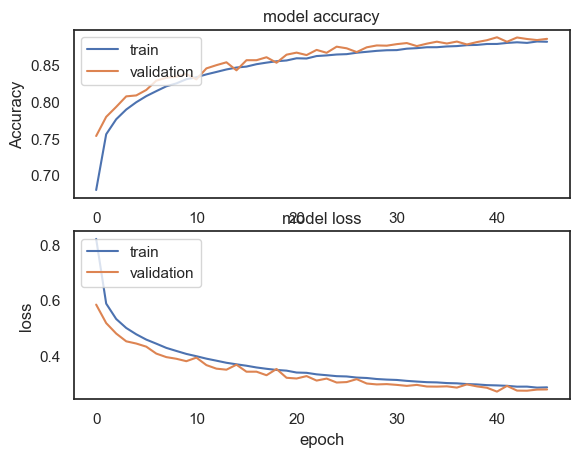

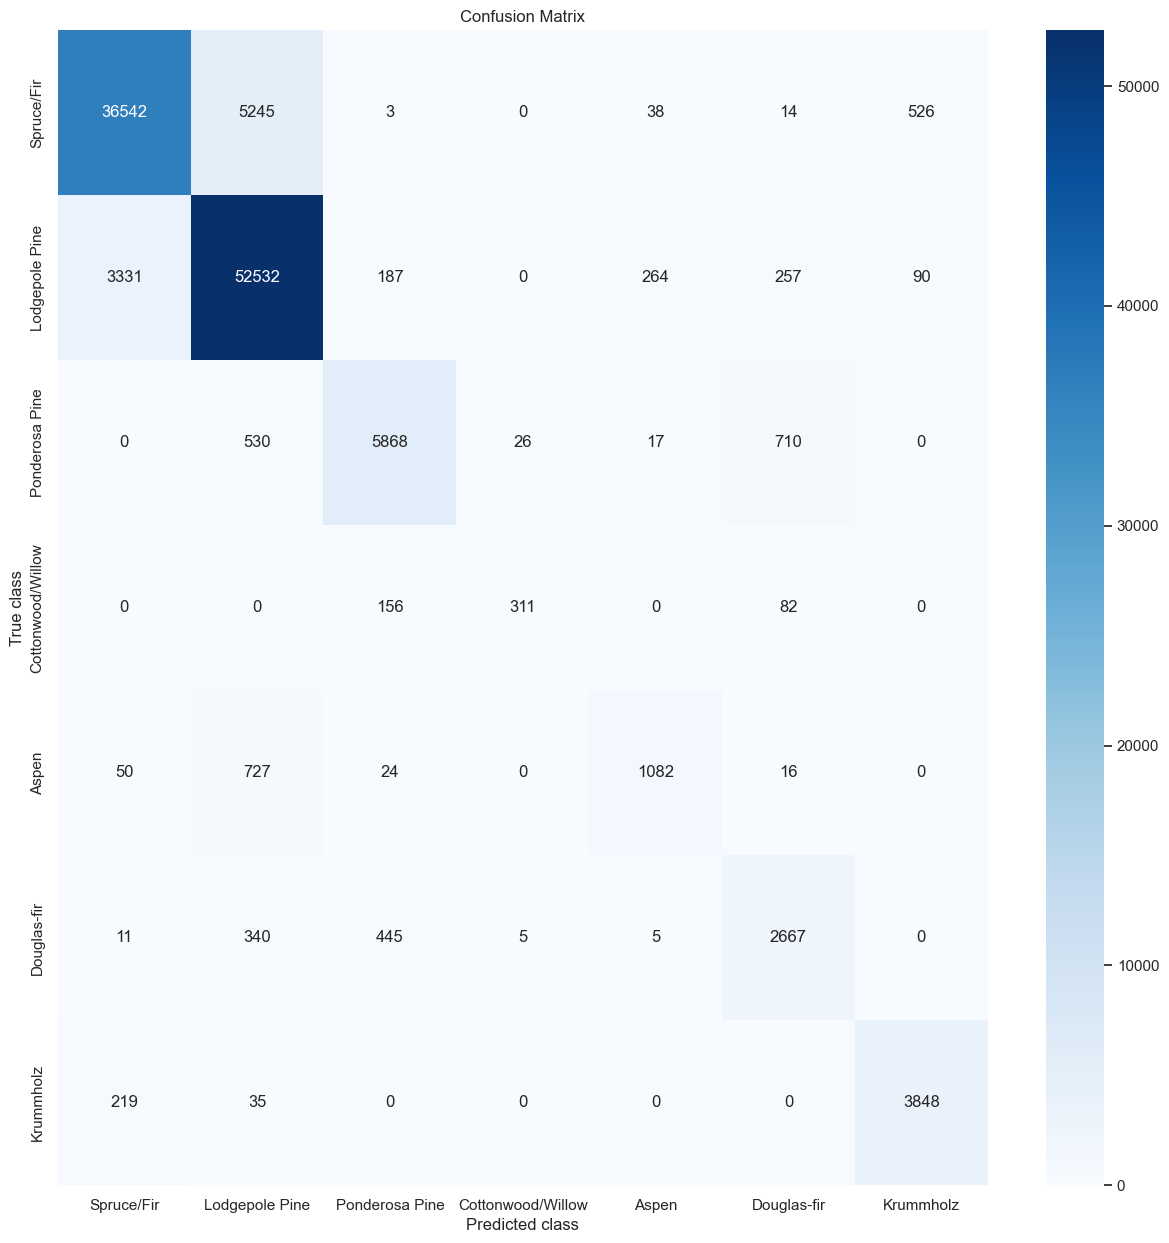

In [292]:
if __name__ == '__main__':
    main()